<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/0722_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 샘플 데이터
np.random.seed(42)
time_steps = 8640 # 5분 단위 한 달
t = np.linspace(0, 50, time_steps)

cpu_usage = 0.5 + 0.3*np.sin(0.2*t) + 0.1*np.random.randn(time_steps)
mem_usage = np.clip(0.2 + 0.001*t + 0.05*np.random.randn(time_steps), 0, 1)
disk_io   = np.clip(0.3 + 0.2*np.random.randn(time_steps), 0, 1)

df = pd.DataFrame({'CPU': cpu_usage, 'Memory': mem_usage, 'DiskI/O': disk_io})

# MinMax 스케일링
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 시계열 윈도우 생성 함수
def create_sequences(data, seq_len=50, pred_steps=10):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_steps):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+pred_steps, 0])  # CPU 예측
    return np.array(X), np.array(y)

SEQ_LEN, PRED_STEPS = 50, 10
X, y = create_sequences(scaled_data, SEQ_LEN, PRED_STEPS)

split_idx = int(len(X)*0.8) # 8:2 로 train test 설정
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [2]:
!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 10.5 MB/s eta 0:00:00


In [3]:
# # 시간에 따른 클러스터 (TimeSeriesKMeans) 를 통해 유사 워크로드 그룹화
# n_clusters = 3
# ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", max_iter=3, random_state=42)
# cluster_labels = ts_kmeans.fit_predict(X_train.reshape(len(X_train), SEQ_LEN, -1))

# print("클러스터 라벨 분포:", np.bincount(cluster_labels))

KeyboardInterrupt: 

In [14]:
# ✅ MAG-D
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, GRU, LSTM, Dense, Layer

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        self.score_dense = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # inputs: (batch, time, hidden_dim)
        scores = self.score_dense(inputs)                 # (batch, time, 1)
        weights = tf.nn.softmax(scores, axis=1)           # attention weight
        context = tf.reduce_sum(weights * inputs, axis=1) # (batch, hidden_dim)
        return context


# MAG-D 모델 (BiGRU → BiLSTM → Attention → Dense)
# 모델 크기 키우고, Huber Loss로 변경
def build_mag_d(seq_len, n_features, pred_steps):
    inputs = tf.keras.Input(shape=(seq_len, n_features))
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
    attn = AttentionLayer()(x)
    outputs = tf.keras.layers.Dense(pred_steps)(attn)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=tf.keras.losses.Huber())  # ✅ Huber로 변경
    return model

model = build_mag_d(SEQ_LEN, X_train.shape[-1], PRED_STEPS)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

# ✅ Auto-regressive rollout 함수 추가
def autoregressive_forecast(model, init_seq, total_steps, seq_len=50, n_features=3):
    pred_seq = []
    current_input = init_seq.copy()
    while len(pred_seq) < total_steps:
        next_pred = model.predict(current_input, verbose=0)[0]  # (10,)
        pred_seq.extend(next_pred.tolist())

        # Memory/DiskIO는 이전 마지막 상태 유지
        new_features = np.zeros((len(next_pred), n_features))
        new_features[:,0] = next_pred
        new_features[:,1:] = current_input[0, -1, 1:]

        # shift해서 새로운 입력 시퀀스 구성
        shifted = np.vstack([current_input[0, len(next_pred):], new_features])
        current_input = shifted[np.newaxis, :, :]
    return np.array(pred_seq[:total_steps])


Epoch 1/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0112 - val_loss: 0.0037
Epoch 2/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 3/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 4/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 5/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 6/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 7/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 8/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 9/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 10/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 11/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 12/100
215/215 ━━━━━━━━

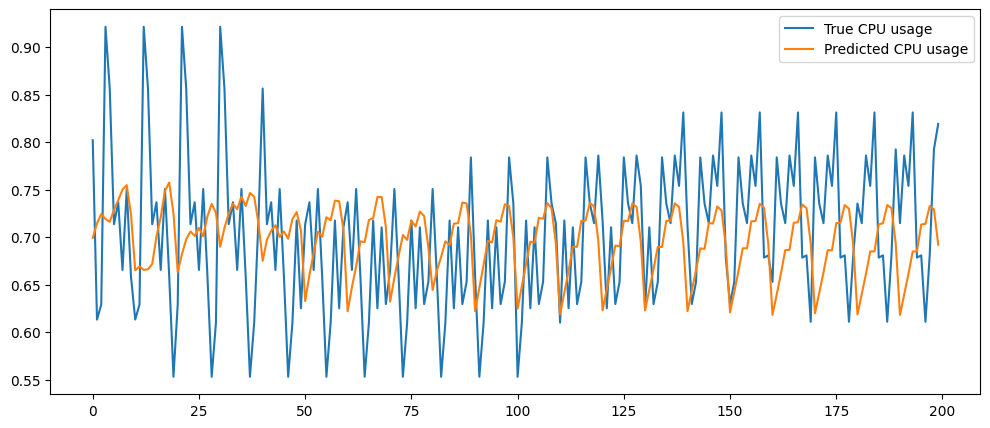

In [15]:
# 시각화
# y_pred = model.predict(X_test)

# import matplotlib.pyplot as plt
# plt.plot(y_test[0], label="True")
# plt.plot(y_pred[0], label="Predicted")
# plt.legend()
# plt.show()

# 테스트셋 첫 입력으로 rollout 예측
init_seq = X_test[0:1]      # (1, 50, 3)
forecast_steps = 200        # 200 step 예측
rollout_pred = autoregressive_forecast(model, init_seq, forecast_steps,
                                       seq_len=SEQ_LEN, n_features=X_train.shape[-1])

# 실제값 (테스트셋 CPU)
true_future = y_test.flatten()[:forecast_steps]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(true_future, label="True CPU usage")
plt.plot(rollout_pred, label="Predicted CPU usage")
plt.legend()
plt.show()

